# Оценка результатов А/В теста ```recommender_system_test```



Тест проводился с целью оценки эффективность новой платежной воронки.

**Техническое задание**

- Название теста: ```recommender_system_test```;

- Группы: А (контрольная), B (новая платёжная воронка);

- Дата запуска: 2020-12-07;

- Дата остановки набора новых пользователей: 2020-12-21;

- Дата остановки: 2021-01-04;

- Аудитория: 15% новых пользователей из региона EU;

- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

- Количество участников теста: 6000

- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

     - конверсии в просмотр карточек товаров — событие product_page
     - просмотры корзины — product_cart
     - покупки — purchase.

**В оценку результатов теста входит:**
1. Оценка соответствия теста ТЗ
2. Оценка корректности проведения теста
3. Исследовательский анализ данных
4. Статистическая обработка и анализ результатов теста

##  1. Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## 2. Загрузка данных и библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math as mth
from scipy import stats as st
import plotly.io as pio
pio.renderers.default = "browser"

In [2]:
# календарь маркетинговых событий на 2020 год

ads = pd.read_csv(r"C:\Users\N\OneDrive\Desktop\study\ipynb\my projects\final_project\AB-test\ab_project_marketing_events.csv")

In [3]:
# все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года

new_users = pd.read_csv(r"C:\Users\N\OneDrive\Desktop\study\ipynb\my projects\final_project\AB-test\final_ab_new_users.csv")

In [4]:
# все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

events = pd.read_csv(r"C:\Users\N\OneDrive\Desktop\study\ipynb\my projects\final_project\AB-test\final_ab_events.csv")

In [5]:
# таблица участников тестов

groups = pd.read_csv(r"C:\Users\N\OneDrive\Desktop\study\ipynb\my projects\final_project\AB-test\final_ab_participants.csv")

In [6]:
def df_info(df):
    
    """Функция выводит размер и информацию о датафрейме head(), info(), информацию о явных дубликатах"""
    
    display(df.head())
    print('\nРазмер датасета', df.shape[0], '\n')
    print('Пропуски в данных и типы данных:\n')
    df.info()
    print('\nЯвные дубликаты:', df.duplicated().sum())

### 2.1. Датасет ```ads```

In [7]:
df_info(ads)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



Размер датасета 14 

Пропуски в данных и типы данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Явные дубликаты: 0


**Пропусков в данных нет, явных дубликатов нет.**

In [8]:
# меняем тип данных

ads['start_dt'] = pd.to_datetime(ads['start_dt'], format='%Y-%m-%d')
ads['finish_dt'] = pd.to_datetime(ads['finish_dt'], format='%Y-%m-%d')

In [9]:
# check

ads.dtypes

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

### 2.2. Датасет ```new_users```

In [10]:
df_info(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



Размер датасета 61733 

Пропуски в данных и типы данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Явные дубликаты: 0


**Данные полные, явных дубликатов нет.**

In [11]:
# меняем тип данных

new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')

In [12]:
# check

new_users.dtypes

user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

### 2.3. Датасет ```events```

In [13]:
df_info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



Размер датасета 440317 

Пропуски в данных и типы данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Явные дубликаты: 0


In [14]:
# смотрим уникальные данные в колонке с пропусками

events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

**Явных дубликатов нет, пропуски есть в колонке ```details```, которая содержит дополнительную информацию о событиях, то есть ее может и не быть. Наличие пропусков объяснимо и логично.**

In [15]:
# меняем тип данных

events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

In [16]:
# check

events.dtypes

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

### 2.4. Датасет ```groups```

In [17]:
df_info(groups)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



Размер датасета 18268 

Пропуски в данных и типы данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Явные дубликаты: 0


**Пропусков и явных дубликатов нет.**

## 3. Оценка корректности проведения теста

### 3.1. Оценка соответствия теста ТЗ

**Техническое задание**

- Название теста: ```recommender_system_test```;

- Группы: А (контрольная), B (новая платёжная воронка);

- Дата запуска: 2020-12-07;

- Дата остановки набора новых пользователей: 2020-12-21;

- Дата остановки: 2021-01-04;

- Аудитория: 15% новых пользователей из региона EU;

- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

- Количество участников теста: 6000

- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

     - конверсии в просмотр карточек товаров — событие product_page
     - просмотры корзины — product_cart
     - покупки — purchase.

In [18]:
# выделим из датасета с группами участников информацию про нужный А/В-тест

groups_ab = groups.query('ab_test == "recommender_system_test"')

In [19]:
# составим список пользователей,попавших в тест

users_from_test = groups_ab['user_id'].unique()

#### Проверим временные рамки набора пользователей

In [20]:
# функция для удаления пересекающихся пользователей из датасетов

def del_extra_users(df, users_lst, delete):
    
    """Функция получает датасет и список с ID пользователей, возвращает измененнный датасет.
    Если параметр delete = False, то остаются только ID из списка.
    Если параметр delete = True, то все ID из списка удаляются из датасета"""
    
    print('Количество пользователей до удаления:', df.shape[0])
    
    if delete:
        df = df.query('user_id not in @users_lst')
    else:
        df = df.query('user_id in @users_lst')
    print('Количество пользователей после удаления:', df.shape[0])
    return df

In [21]:
# обрежем датасет с новыми пользователями до тех пользователей, которые вошли в тест

new_users_in_test = del_extra_users(new_users, users_from_test, False)

Количество пользователей до удаления: 61733
Количество пользователей после удаления: 6701


In [22]:
print('Начало набора новых пользователей:', new_users_in_test['first_date'].min())

Начало набора новых пользователей: 2020-12-07 00:00:00


In [23]:
print('Окончание набора новых пользователей:', new_users_in_test['first_date'].max())

Окончание набора новых пользователей: 2020-12-21 00:00:00


**Время начала и окончания набора новых пользователей соответствует ТЗ.**

#### Проверим временные рамки проведения теста

In [24]:
# обрежем датасет с событиями до тех пользователей, которые вошли в тест

events_in_test = del_extra_users(events, users_from_test, False)

Количество пользователей до удаления: 440317
Количество пользователей после удаления: 24698


In [25]:
print('Время начала теста', events_in_test['event_dt'].min())

Время начала теста 2020-12-07 00:05:57


In [26]:
print('Время окончания теста', events_in_test['event_dt'].max())

Время окончания теста 2020-12-30 12:42:57


**После нового года про тест, похоже, забыли. Требование ТЗ не выполнено.**

#### Проверим долю пользователей из европейского региона, вошедших в тест

In [27]:
eu_ratio = (
            round(new_users_in_test.query('region == "EU"')['user_id'].nunique() 
            / new_users.query('region == "EU"')['user_id'].nunique() 
            * 100,
                  2)
            )
print('Доля новых пользователей из Европы, вошедших в тест:',eu_ratio,'%')

Доля новых пользователей из Европы, вошедших в тест: 13.73 %


**По ТЗ нужно было набрать 15% пользователей из EU. Набрали около 12%. Требование ТЗ не выполнено/

#### Проверим число участников теста

In [28]:
# посмотрим количество участников теста

groups_ab['user_id'].nunique()

6701

Количество участников теста соответствует ТЗ.

По ТЗ мы должны оценить поведение пользователей в течение 14 дней, так как тест закончили раньше, то в тест должны войти только те пользователи, которые закончили свой 14-дневный период к 29.12 23:59:59. То есть это те пользователи, которые пришли в период с 07.12.2020 по 15.12.2020.

In [29]:
# список новых пользователей, пришедших после 15.12.2020

new_users_late = new_users.query('first_date > "2020-12-16"')['user_id'].unique()

In [30]:
# смотрим, попали ли данные пользователи в тест

count = 0
for i in new_users_late:
    if i in users_from_test:
        count += 1
if count == 0:
    print('Все пользователи в тесте прошли 14дневный период')
else:
    print(count, 'пользователей, не прошедних 14дневный период, попали в тест')

2387 пользователей, не прошедних 14дневный период, попали в тест


То есть, необходимо сократить количество пользователей, участвовавших в тесте на 2387, тогда, останется всего чуть больше 4000, хотя по ТЗ нам требуется 6000.

Есть второй вариант: можно **сократить горизонт анализ до 10 дней** (максимально возможный срок жизни пользователей, зарегистрировавшихся до 20.12.2020 включительно; 30.12.2020 придется отбросить, так как данные представлены не за полный день).
Таким образом, мы сохраним в тесте всех отобранных пользователей.

В любом случае, условия ТЗ будут не выполнены, но можно будет оценить результат.

Так как чем больше пользователей, тем точнее тест, посмотрим, что произойдет с воронкой на **горозонте анализа 10 дней**.

In [31]:
# выделяем пользователей, совершавших события до 30.12.2020

events_in_test = events_in_test.query('event_dt < "2020-12-30"')

**Это события для пользователей, пришедших с 07.12.2020 по 20.12.2020 включительно, участвовавших в тесте в течение 10 дней.** 

**С этим датасетом будем работать дальше.**

Проверим временные рамки после удаления всех пользователей.

In [32]:
print('Время начала теста', events_in_test['event_dt'].min())

Время начала теста 2020-12-07 00:05:57


In [33]:
print('Время окончание теста:', events_in_test['event_dt'].max())

Время окончание теста: 2020-12-29 23:38:29


**Итак, тест продолжался с 07.12.2020 до 29.12.2020 включительно.**

### 3.2. Оценка корректности деления на группы

#### Оценка количества пользователей в каждой группе

In [34]:
groups_ab.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,3824
B,2877


**Группа А содержит больше пользователей на 25%, но это допустимо, так как группа А - контрольная.**

#### Оценка пересечения пользователей в группах

In [35]:
# смотрим пересечение групп по пользователям

len(groups_ab.query('group == "A"').merge(groups_ab.query('group == "B"'), on='user_id'))

0

**Пользователи в каждой группе уникальны.**

#### Оценка пересечения с конкурирующим тестом

In [36]:
# смотрим, какие конкурирующие тесты имеются

groups.groupby('ab_test').agg({'user_id':'nunique'})

,user_id
ab_test,
interface_eu_test,11567
recommender_system_test,6701


Итак, имеются два теста. Необходимо посмотреть, пересекаются ли в них пользователи.

In [37]:
# выделим конкурирующий тест в отдельный датасет

interface_test = groups.query('ab_test == "interface_eu_test"')

In [38]:
# ищем количество пересекающихся пользователей

tests = groups_ab.merge(interface_test, on='user_id', suffixes=('_ab', '_eu'))
len(tests)

1602

Есть пересечение со вторым тестом. Для чистоты картины удалим пользователей, которые попали в группу В конкурирующего теста. Пользователей из группы А конкурирующего теста можно оставить, так как на них изменения не применялись.

In [39]:
# составляем список всех пользователей, что вошли в В группу конкурирующего теста

users_from_another_test = tests.query('group_eu == "B"')['user_id'].unique()

In [40]:
# удаляем пересекающихся пользователей из датасета с группами

groups_ab = del_extra_users(groups_ab, users_from_another_test, True)

Количество пользователей до удаления: 6701
Количество пользователей после удаления: 5918


In [41]:
# удаляем пересекающихся пользователей из датасета с новыми пользователями

new_users_in_test = del_extra_users(new_users_in_test, users_from_another_test, True)

Количество пользователей до удаления: 6701
Количество пользователей после удаления: 5918


In [42]:
# удаляем пересекающихся пользователей из датасета с событиями

events_in_test = del_extra_users(events_in_test, users_from_another_test, True)

Количество пользователей до удаления: 24694
Количество пользователей после удаления: 21838


Пользователей осталось чуть меньше 6000, но зато данные будут более чистые.

#### Посмортим равномерность и подобие деления пользователей

In [43]:
# добавим информацию о группах в датасет с пользователями

users = new_users_in_test.merge(groups_ab, on='user_id', how='inner')
users.shape[0]

5918

In [44]:
# смотрим распределение пользвателей по группам

users.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,3385
B,2533


Пользователей в А группе на 25% больше. Посмотрим, как набирались группы.

In [45]:
# смотрим распределение пользователей по группам и датам

new_users_by_date = (
                        users
                            .groupby(['first_date','group'], as_index=False)
                            .agg({'user_id':'nunique'})
)
new_users_by_date.head(6)

,first_date,group,user_id
0,2020-12-07,A,321
1,2020-12-07,B,237
2,2020-12-08,A,183
3,2020-12-08,B,134
4,2020-12-09,A,126
5,2020-12-09,B,96


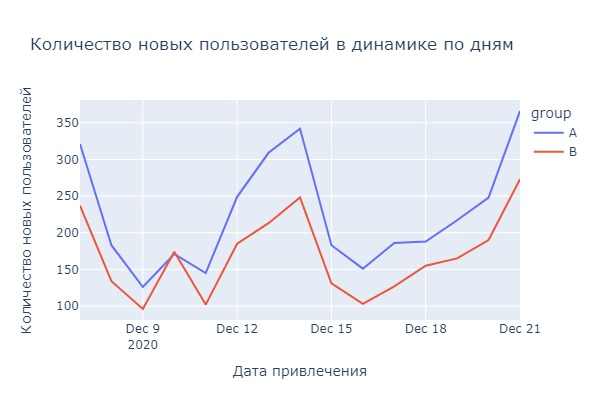

In [46]:
# визуализируем привлечение новых пользователей в динамике

fig = px.line(new_users_by_date,
              x='first_date',
              y='user_id',
              color='group',
             height=400,
             width=600,
             title='Количество новых пользователей в динамике по дням',
             labels={'first_date': 'Дата привлечения',
                     'user_id': 'Количество новых пользователей'})
fig.show(renderer='jpeg')

**В среднем мы видим, что пользователей приходили равномерно меньше в группу В.**

In [47]:
# смотрим распределение пользвателей по группам и устройствам

users.pivot_table(columns=['device'], index=['group'], values='user_id', aggfunc='nunique')

device,Android,Mac,PC,iPhone
group,,,,
A,1488,314,883,700
B,1168,220,612,533


С устройствами аналогично - в группу В набирали примерно на 30% меньше юзеров.

In [48]:
# смотрим распределение пользвателей по устройствам, группам и датам

new_users_by_device = (users
                       .groupby(['first_date','group','device'], as_index=False)
                       .agg({'user_id':'nunique'})
                      )
new_users_by_device.head()

,first_date,group,device,user_id
0,2020-12-07,A,Android,134
1,2020-12-07,A,Mac,25
2,2020-12-07,A,PC,79
3,2020-12-07,A,iPhone,83
4,2020-12-07,B,Android,114


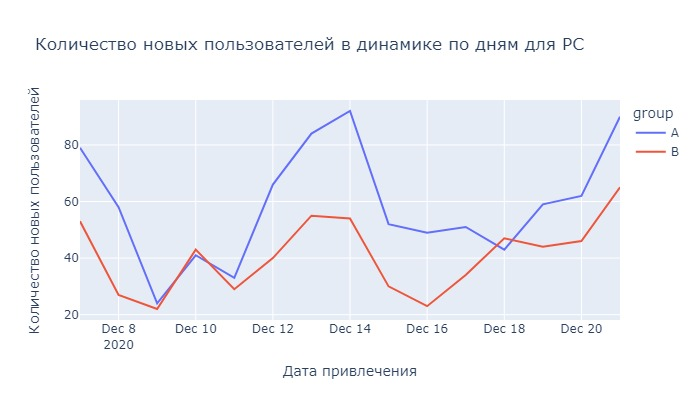

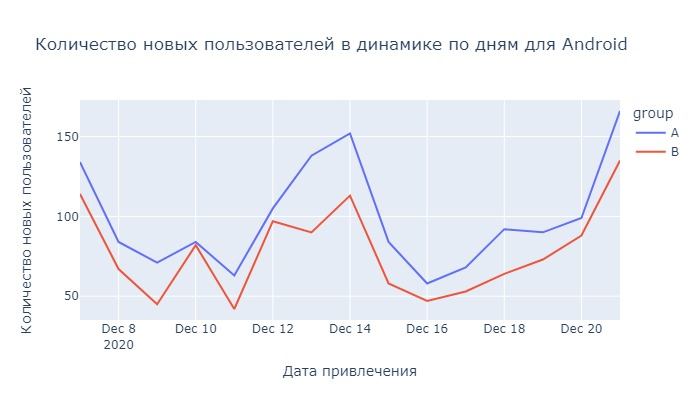

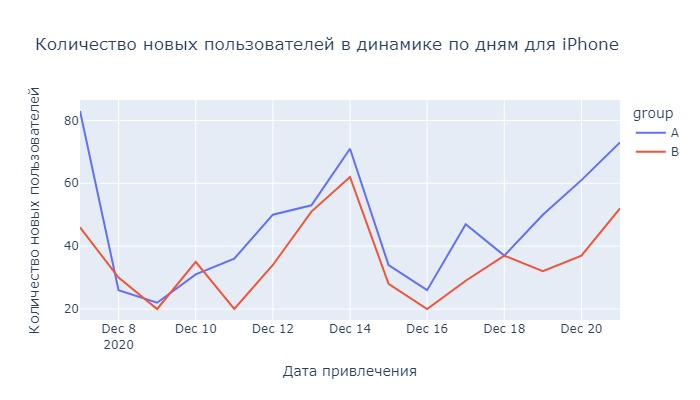

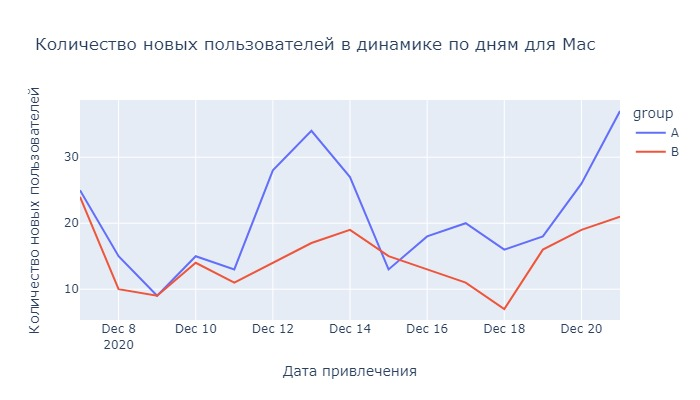

In [49]:
# визуализируем новых пользователей в динамике в зависимости от устройства

for i in users['device'].unique():
    fig = px.line(new_users_by_device.query('device == @i'),
              x='first_date',
              y='user_id',
              color='group',
             height=400,
             width=700,
             title='Количество новых пользователей в динамике по дням для ' + i,
             labels={'first_date': 'Дата привлечения',
                     'user_id': 'Количество новых пользователей'})
    fig.show(renderer='jpeg')

Сохраняется та же тенденция и для каждого устройства в отдельности: в группу А набирают пропорционально больше устройств.

### 3.3. Пересечение теста с маркетинговыми активностями <a id='bonferroni'></a>

Посмотрим, какие активности запранированы на период с 07.12.2020 по 04.01.2021.

In [50]:
ads.query('start_dt >= "2020-12-07" and start_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Мы видим запланированное промо с 25 декабря по 3 января, которое будет проводится в нашем целевом регионе - Европе. К тому моменту когорты уже набраны, поэтому на привлечение пользователей данное промо влиять не будет. Однако, может влиять на следующие этапы воронки. Так как у нас есть конрольная группа, данное временное явление не должно помешать сделать выводы. Хотя на будущее стоит учитывать сезонность и различные праздники, так как в целом они влияют на поведение пользователя.

Вторая акция - лотерея - проводится в СНГ, что не может повлиять на наших пользователей.

## 4. Исследовательский анализ данных

### 4.1. Изучим неактивных пользователей

In [51]:
# посмотрим, все ли привлеченные пользователи совершали действия

# количество уникальных пользователей, совершивших хотя бы одно действие

events_in_test['user_id'].nunique()

3244

In [52]:
# количество пользователей, отобранных для теста

groups_ab['user_id'].nunique()

5918

Вот это сюрприз! Больше половины отобранных для теста пользователей (55%) не совершили ни одного действия. Стоит проанализировать этих пользователей и понять, стоит их учитывать при обработке результатов теста или нет.

In [53]:
# оценим количество неактивных юзеров в каждой группе 

users_in_test = events_in_test['user_id'].unique()
no_events = (
            groups_ab
             .query('user_id not in @users_in_test')
             .groupby('group', as_index=False)
             .agg({'user_id':'nunique'})
             .merge(users
                    .groupby('group', as_index=False)
                    .agg({'user_id':'nunique'}), on='group', suffixes=('_no_events', '_with_events'))
            )
no_events['percent_of_nonactive_users'] = round(no_events['user_id_no_events'] / no_events['user_id_with_events'] * 100, 1)
no_events

,group,user_id_no_events,user_id_with_events,percent_of_nonactive_users
0,A,963,3385,28.4
1,B,1711,2533,67.5


Из группы B почти 70% пользователей не совершали больше никаких действий. Нужно разбираться, возможно, это техническая ошибка. Так как целевые метрики в тесте касаются пользователей внутри воронки, придется оставить в тесте только тех польхователей, которые совершали действия.

In [54]:
# составляем датасет с пользователями, которые не совершали никаких действий

nonactive_users = users.query('user_id not in @users_in_test')

In [55]:
# посмотрим, как неактивные пользователи распределеяются по датам

nonactive_by_date = nonactive_users.groupby(['first_date', 'group'], as_index=False).agg({'user_id':'nunique'})
nonactive_by_date.head()

,first_date,group,user_id
0,2020-12-07,A,184
1,2020-12-07,B,78
2,2020-12-08,A,94
3,2020-12-08,B,96
4,2020-12-09,A,56


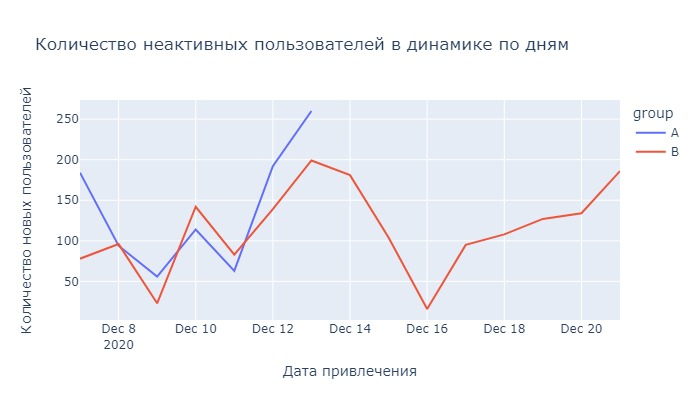

In [56]:
fig = px.line(nonactive_by_date,
              x='first_date',
              y='user_id',
              color='group',
             title='Количество неактивных пользователей в динамике по дням',
              labels={'first_date': 'Дата привлечения',
                     'user_id': 'Количество новых пользователей'},
             width=700,
             height=400
             )
fig.show(renderer='jpeg')

Пользователи из группы А с 13.12 перестали оставаться неактивными. Возможно, тут имеет место либо техническая ошибка, либо некорректно велись логи.

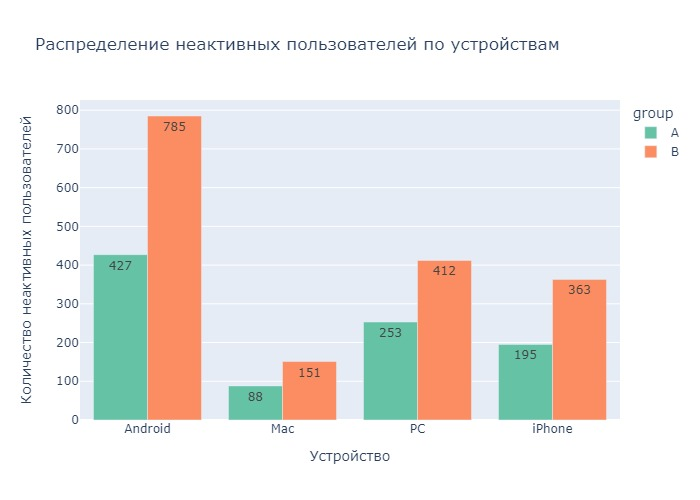

In [57]:
# посмотрим, как неактивные пользователи распределяются по устройствам

nonactive_by_device = nonactive_users.groupby(['group','device'], as_index=False).agg({'user_id':'nunique'})

fig =px.bar(
                nonactive_by_device,
                x='device', 
                y='user_id', 
                color='group',
                barmode='group',
                text_auto=True,
                color_discrete_sequence=px.colors.qualitative.Set2,
                title='Распределение неактивных пользователей по устройствам',
                labels={'device':'Устройство', 'user_id':'Количество неактивных пользователей'})

fig.show(renderer='jpeg')

Вне зависимости от используемого девайса пользователи из В группы примерно в 2 раза чаще остаются неактивными. То есть девайс не влияет на активность пользователя.

**Похоже, такой перекос в активности новых пользователей связан с технической ошибкой или некорректным ведением логов. Чтобы некорректные данные не повлияли на результат нашего АВ-теста, неактивных пользователей в конечные расчеты брать не будем.**

### 4.2. Количество событий на пользователя

In [58]:
# добавим в датасет с событиями информацию о группе, в которую попал пользователь

events_in_test.loc[events_in_test['user_id'].isin(groups_ab.query('group == "A"')['user_id'].unique()), 'group'] = 'A'
events_in_test.loc[events_in_test['user_id'].isin(groups_ab.query('group == "B"')['user_id'].unique()), 'group'] = 'B'

In [59]:
events_in_test.head()

,user_id,event_dt,event_name,details,group
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,A
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,B
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,A
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,B


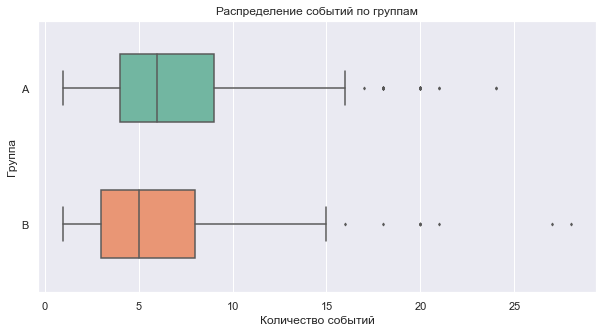

In [60]:
# посмотрим, сколько событий совершают пользователи в группах

events_by_users = events_in_test.groupby(['group','user_id'], as_index=False).agg({'event_name':'count'})

sns.set(rc={'figure.figsize':(10,5)})
ax = sns.boxplot(x='event_name', y='group', data=events_by_users, orient="h", palette="Set2", width=0.5, fliersize=2)
ax.set_title('Распределение событий по группам')
ax.set(xlabel='Количество событий')
ax.set(ylabel='Группа');

In [61]:
# сгруппируем данные по группам

events_by_users.groupby('group').agg({'event_name':'median'})

,event_name
group,
A,6.0
B,5.0


События по группам распределены неравномерно. 

**Пользователи в контрольной группе совершают в среднем на 1 событие больше**.

### 4.3. Динамика количества событий по группам

In [62]:
# создадим колонку с датой и сгруппируем данные по датам и группам

events_in_test['date'] = events_in_test['event_dt'].dt.date
events_by_date = events_in_test.groupby(['date','group'], as_index=False).agg({'event_name':'count'})
events_by_date.columns = ['date', 'group', 'events_count']

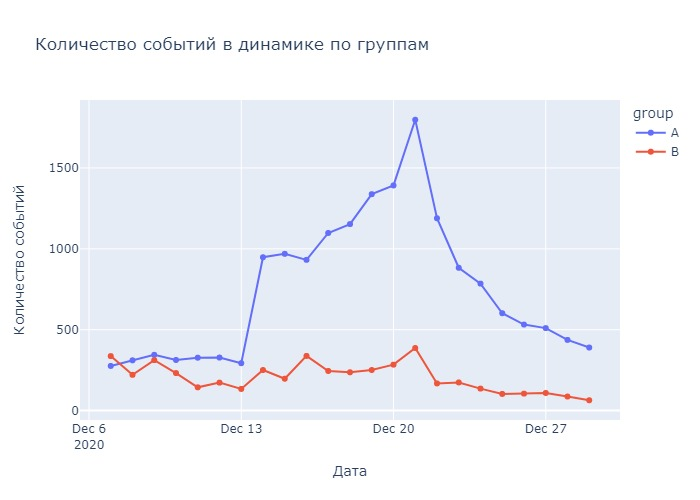

In [63]:
# строим количество событий в динамике по группам

fig = px.line(events_by_date,
              x='date',
              y='events_count',
              color='group',
              markers=True,
              height=500,
              width=700,
             title='Количество событий в динамике по группам',
             labels={'date': 'Дата',
                     'events_count': 'Количество событий'})
fig.show(renderer='jpeg')

Сначала первую неделю до 13.12 событий в группе B хоть и было меньше, но сопоставимо  меньше. 
Дальше случился резкий скачок в группе А. 
После 21.12.2020 наблюдается резкое падение в контрольной группе А. В тестовой группе изменения не так заметны.
Складыввается впечатление, что либо перепутали группы, либо на контрольную группу было оказано какое-то влияние, вызвывшее пик.

**Однако очевидно, что на протяжении всего теста количество событий меньше в группе В.**

Чтобы оценить динамику, посмотрим также изменение количества событий на одного пользователя.

In [64]:
# посмотрим, как меняется среднее количество событий на одного пользователя со временем

events_by_date_per_user = (events_in_test
                           .groupby(['date','group'], as_index=False)
                           .agg({'event_name':'count', 'user_id':'nunique'})
                          )
events_by_date_per_user.columns = ['date', 'group', 'events_count', 'users_count']
events_by_date_per_user['avg_ev_per_user'] = round(events_by_date_per_user['events_count'] /
                                                   events_by_date_per_user['users_count'],
                                                   1)
events_by_date_per_user.head()

,date,group,events_count,users_count,avg_ev_per_user
0,2020-12-07,A,276,128,2.2
1,2020-12-07,B,337,152,2.2
2,2020-12-08,A,311,146,2.1
3,2020-12-08,B,221,105,2.1
4,2020-12-09,A,345,157,2.2


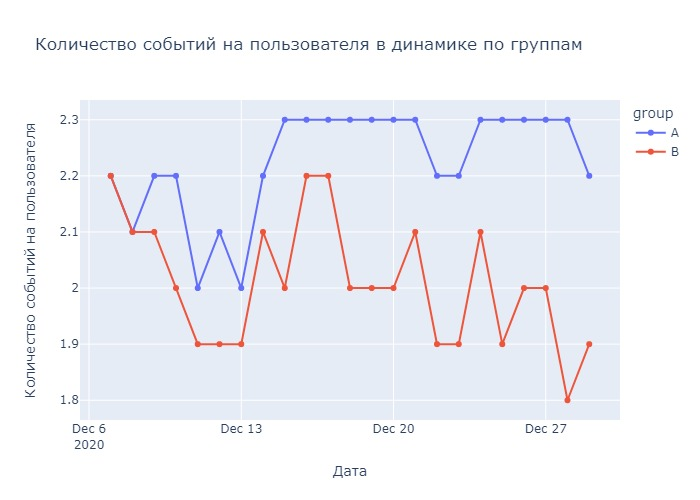

In [65]:
# визуализируем количество событий на пользователя в динамике по группам

fig = px.line(events_by_date_per_user,
              x='date',
              y='avg_ev_per_user',
              color='group',
              markers=True,
              height=500,
              width=700,
             title='Количество событий на пользователя в динамике по группам',
             labels={'date': 'Дата',
                     'avg_ev_per_user': 'Количество событий на пользователя'})
fig.show(renderer='jpeg')

**Тут очевидно, что в среднем пользователи группы В менее активны, чем пользователи контрольной группы.**

### 4.4. Конверсия в воронке по группам

In [66]:
# построим сравнительную таблицу с воронками для двух групп

funnels = events_in_test.pivot_table(columns='event_name', index='group', values='user_id', aggfunc='nunique')
funnels['cr_for_product_page, %'] = round(funnels['product_page'] / funnels['login'] * 100, 1)
funnels['cr_for_product_cart, %'] = round(funnels['product_cart'] / funnels['product_page'] * 100, 1)
funnels['cr_for_purchase, %'] = round(funnels['purchase'] / funnels['product_cart'] * 100, 1)
funnels = funnels.T.drop(index=['login','product_cart','product_page','purchase'])
funnels.columns = ['A','B']
funnels['difference, %'] = ((funnels['B'] - funnels['A']) / funnels['A']) * 100
funnels

,A,B,"difference, %"
event_name,,,
"cr_for_product_page, %",64.9,55.8,-14.021572
"cr_for_product_cart, %",46.3,49.0,5.831533
"cr_for_purchase, %",106.2,100.4,-5.461394


Мы видим, что:

- конверсия в product_page снизилась почти на 14%;
- конверсия в product_cart увеличилась на 5,8%, но нужно проверить это отличие на статистическую значимость;
- конверсия в purchase уменьшилась на 5,5%, но нужно проверить это отличие на статистическую значимость.

Также стоит отметить, что мы имеем особенность данных. Количество покупок в обеих группах выше, чем посещение корзины. Это может быть особенность приложения, где пользователь может купить в обход корзины, но скорее всего дело в задержках в логах. Мы будем оценивать изменение, поэтому оставим так.


## 5. Оценка результатов АВ-теста

In [67]:
# разделим датасет с событиями по группам

events_a = events_in_test.query('group == "A"')
events_b = events_in_test.query('group == "B"')

In [68]:
# функция для построения воронки для группы

def funnel_for_group(group):
    
    '''Функция принимает группу из АВ теста и строит воронку, рассчитывая и конверсию, и конверсию по этапам воронки.
       Возвращает воронку.'''
    
    funnel = (
                group
                    .groupby('event_name',as_index=False)
                    .agg({'user_id':'nunique'})
                    .sort_values(by='user_id', ascending=False)
                    .reset_index(drop=True)
                )
    funnel['cr, %'] = round(funnel['user_id'] / group['user_id'].nunique() * 100, 2)
    funnel['stage_conversion, %'] = (
                                    round(funnel['user_id'] 
                                            / funnel.shift(1,
                                                           fill_value=group['user_id']
                                                           .nunique()
                                                          )['user_id']
                                            * 100, 
                                              1)
                                    )
    return funnel

In [69]:
# функция для расчета статистической значимости конверсии в группах

def get_z_test(group_a, group_b, alpha, m):
    
    '''Функция принимает 2 группы из АВ теста, уровень значимости alpha,
         показатель m, который равен:
                                     - поправке Бонферрони при множественном сравнении;
                                     - 1, при одиночном сравнении.
         Функция проводит сравнение долей в воронках.
         Функция возвращает датасет с данными о результатах сравнения.'''
    
    # создаем воронки для групп
    funnel_a = funnel_for_group(group_a).drop(0).reset_index(drop=True)
    funnel_b = funnel_for_group(group_b).drop(0).reset_index(drop=True)
    
    # создаем датафрейм для записи результатов
    z_test = pd.DataFrame(data=None, index=funnel_a['event_name'], columns=['p_value', 'result'], dtype=None, copy=None)
    
    # перебираем все этапы воронки
    for i in range(0, z_test.shape[0]):
        
        # создаем списки успехов и попыток
        successes = [funnel_a['user_id'][i], funnel_b['user_id'][i]]
        trials = [group_a['user_id'].nunique(), group_b['user_id'].nunique()]

        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2 

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  
        
        # рассчитываем p-value
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        # записываем p-value в результирующую таблицу
        z_test['p_value'][i] = p_value
        
        # оцениваем результат проверки гипотезы и выводим в результирующую таблицу
        if p_value < alpha/m:
            z_test['result'][i] = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'
        else:
            z_test['result'][i] = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию различной'
            
    print('Результат статистической проверки гипотезы:')
    
    return z_test

Мы собираемся проводить множественное сравнение долей - 3. Для того, чтобы снизить вероятность ошибки первого рода, используем поправку Бонферрони m = 3.

In [70]:
# проводим оцекну статистической значимости различий между новой и старой воронкой

get_z_test(events_a, events_b, 0.05,3)

Результат статистической проверки гипотезы:


,p_value,result
event_name,,
product_page,0.000004,Отвергаем нулевую гипотезу: между долями есть ...
purchase,0.01765,"Не получилось отвергнуть нулевую гипотезу, нет..."
product_cart,0.144121,"Не получилось отвергнуть нулевую гипотезу, нет..."


Итак, статистически значимых различий в конверсии в product_cart и purchase нет.
Различия в конверсиях в product_page значимы, но данная конверсия уменьшилась почти на 14%, хотя предполагалось, что она увеличиться на 10%.

В целом, тест показал, что новая рекомендательная система повлияла на воронку в отрицательную сторону, и применять ее не стоит.

## Выводы

Была проведена оценка результатов А/В-теста  оценку результатов теста ```recommender_system_test```.

Оценка включала следующие этапы:

1. Оценка соответствия теста ТЗ
2. Оценка корректности проведения теста
3. Исследовательский анализ данных
4. Статистическая обработка и анализ результатов теста

### Оценка соответствия теста техническому заданию

1.1. Название теста: recommender_system_test;

1.2. Группы: А (контрольная), B (новая платёжная воронка);

1.3. Дата запуска: 2020-12-07 - **соттветствует**

1.4. Дата остановки набора новых пользователей: 2020-12-21 - **соответствует**

1.5. Дата остановки: 2021-01-04 - **НЕ соттветствует**, *тест окончен 29.12.2020*

1.6. Аудитория: 15% новых пользователей из региона EU - **соответствует**

1.7. Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

1.8. Количество участников теста: 6000 - **НЕ соответствует.** *Фактически в тесте участвовали 3244 пользователя в обеих группах суммарно.*

1.9. Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

**НЕ соответствует.** *Было принято решение сократить горизонт анализ до 10 дней (максимально возможный срок жизни пользователей, зарегистрировавшихся до 20.12.2020 включительно. Таким образом, мы сохраним в тесте всех отобранных пользователей.*


**Итак, тест проводился с отклонением от технического задания.**

### Оценка корректности проведения теста

#### Оценка корректности деления на группы

Пользователи в группах не пересекаются, пользователей в контрольной группе больше, чем в тестовой, но это допустимо.

Было обнаружено пересечение аудитории с параллельным тестом  ```interface_eu_test```. Для чистоты картины пользователи, которые попали в группу В конкурирующего теста были удалены. Пользователей из группы А конкурирующего теста остались, так как на них никакие изменения не применялись.

Исследование аудитории показало, что группы подобны.

#### Пересечение теста с маркетинговыми активностями

С 25 декабря по 3 января запланированное промо, которое будет проводиться в нашем целевом регионе - Европе. К тому моменту когорты уже набраны, поэтому на привлечение пользователей данное промо влиять не будет. Однако, может влиять на следующие этапы воронки. Так как у нас есть конрольная группа, данное временное явление не должно помешать сделать выводы. Хотя на будущее стоит учитывать сезонность и различные праздники, так как в целом они влияют на поведение пользователя.

### Исследовательский анализ данных

Больше половины отобранных для теста пользователей (55%) не совершили ни одного действия.
Из группы B почти 70% вновь зарегистрированных пользователей не совершали больше никаких действий. 

**Похоже, такой перекос в активности новых пользователей связан с технической ошибкой или некорректным ведением логов. Чтобы некорректные данные не повлияли на результат АВ-теста, неактивных пользователей в конечные расчеты не брали, за счет чего количество пользователей в тесте сократилось с 5918 до 3244 пользователей.**

События по группам распределены неравномерно. Пользователи в контрольной группе совершили почти в 4 раза больше событий.
Количество событий на пользователя в контрольной группе выше - 7 против 6.

В динамике на протяжении всего теста количество событий меньше в группе В.

Складыввается впечатление, что либо перепутали группы, либо на контрольную группу было оказано какое-то влияние.

### Статистическая обработка и анализ результатов теста

При сравнении двух воронок выяснили:

- конверсия в product_page **снизилась почти на 14%** - это **статистически значимый результат**;
- конверсия в product_cart **увеличилась на 5,8%**, но **не имеет статистической значимости**;
- конверсия в purchase **уменьшилась на 5,5%**, но **не имеет статистической значимости**.

Также стоит отметить, что мы имеем особенность данных. Количество покупок в обеих группах выше, чем посещение корзины. Это может быть особенность приложения, где пользователь может купить в обход корзины (например, кнопка "купить в один клик"), или дело может быть в задержках в логах.

**В целом, тест показал, что новая рекомендательная система повлияла на воронку в отрицательную сторону, и применять ее не стоит, однако, в связи с несоответствием с ТЗ, некоторыми странностями в данных и пересечение с маркетинговыми активностями и Рождеством и Новым Годом, рекомендуется провести данный АВ-тест повторно, так как полученным результатам доверять не стоит.**

## Рекомендации

1. Стоит поднять логи и понять, почему так много пользователей остаются неактивными.
2. Не стоит планировать А/В-тест в высокий сезон маркетинговой активности (праздники и т.д.), так как это может влиять на поведение пользователей.
3. Необходимо следить, чтобы пользователи не попадали в параллельные А/В-тесты.
4. Необходимо следить за выполнением требований ТЗ.
5. Данные А/В-тест необходимо повторить.